In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

#### Define the VAE Architecture
In a VAE, you have an encoder, a latent space, and a decoder. The encoder compresses the input into a latent vector z, and the decoder reconstructs the input from this latent vector.

In [20]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(784, 400)  # Fully connected layer 1
        self.fc21 = nn.Linear(400, 20)  # Latent space mean
        self.fc22 = nn.Linear(400, 20)  # Latent space log-variance

        # Decoder layers
        self.fc3 = nn.Linear(20, 400)   # Latent space back to hidden dimension
        self.fc4 = nn.Linear(400, 784)  # Hidden dimension back to original image size

    def encode(self, x):
        h1 = F.relu(self.fc1(x))  # First layer encoding with ReLU activation
        return self.fc21(h1), self.fc22(h1)  # Return mean and log-variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)  # Random normal noise
        return mu + eps * std  # Reparameterize the latent space

    def decode(self, z):
        h3 = F.relu(self.fc3(z))  # First decoder layer with ReLU activation
        return torch.sigmoid(self.fc4(h3))  # Output layer with sigmoid to generate image

    def forward(self, x):
        mu, logvar = self.encode(x)  # Get mean and log variance from the encoder
        z = self.reparameterize(mu, logvar)  # Get the latent variable z
        return self.decode(z), mu, logvar  # Return decoded output, mean, and log variance

#### Define the Loss Function (Reconstruction + KL Divergence)
The VAE loss consist of two parts
* Reconstruction loss: Measures how well the VAE reconstructs the inputs.
* KL divergence loss: Measures how close the latent distribution is to the normal distribution N(0,1)

In [21]:
def loss_function(reconstructed_x, x, mu, logvar):
    # Reconstruction Loss (binary cross entropy)
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_x, x.view(-1, 28*28), reduction='sum')

    # KL Divergence Loss
    kl_loss = -0.5 * torch.sum(1 + logvar -mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_loss

#### Prepare MNIST Dataset

In [22]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

# Load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

#### Train the VAE

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1  # Set the number of training epochs
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed_x, mu, logvar = model(data)
        
        # Compute loss
        loss = loss_function(reconstructed_x, data, mu, logvar)
        train_loss += loss.item()
        
        # Backprop and optimize
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")
    


Epoch 1, Loss: 164.30511676432292


#### Generate New Samples

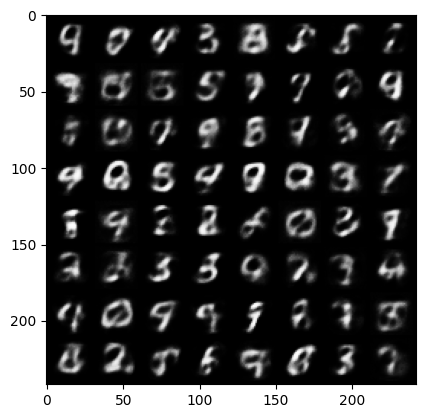

In [32]:
import matplotlib.pyplot as plt
import torchvision
import torchvision
from torchvision.utils import make_grid

# Set the model to evaluation mode
model.eval()

# Sample from a standard normal distribution
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    sample = model.decode(z).cpu()

# Plot the generated images
sample = sample.view(64, 1, 28, 28)
grid = torchvision.utils.make_grid(sample, nrow=8)
plt.imshow(grid.permute(1, 2, 0))
plt.show()